In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1652471119904577923, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10850151817754835875
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4637982732120134068
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14800692839
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15623272567952576328
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [3]:
!pip install keras scikit-learn imbalanced-learn

## Imports for the Convolutional VAE and LFW dataset

In [4]:
import numpy as np
import keras
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()
from keras.preprocessing.image import ImageDataGenerator
from keras import Model
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Conv2D, Activation, Dense, Lambda, Input, MaxPooling2D, Dropout, Flatten, Reshape, UpSampling2D, Concatenate
from keras.losses import mse, binary_crossentropy
from keras import backend as K
from keras.utils import plot_model, to_categorical
from keras.models import Sequential
from keras.layers import Dense
from PIL import Image

Using TensorFlow backend.


# LFW Dataset Download & Preprocessing

number of examples: 2053
dimensionality of images: (154, 154)
number of unique classes (people): 24


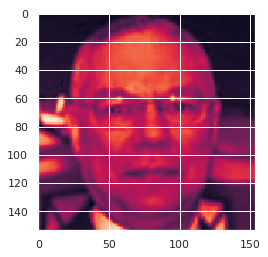

In [5]:
#Downloading the dataset as black and white images
lfw_people = fetch_lfw_people(min_faces_per_person=35, color=False, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))

X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('number of examples: {}'.format(y.shape[0]))
print('dimensionality of images: {}'.format(X.shape[1:]))
print('number of unique classes (people): {}'.format(n_classes))
plt.imshow(lfw_people.images[0].astype(np.uint8))

George W Bush


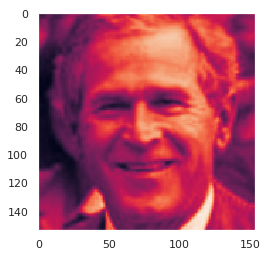

In [6]:
i = np.random.randint(len(lfw_people.images))
plt.imshow(lfw_people.images[i].astype(np.uint8))
plt.grid(False)
print(target_names[y[i]])

In [0]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1)

In [8]:

batch_size = 256
test_split = 0.2
base_lr = 0.001
epochs = 100

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, 
                                                    stratify=y, random_state=42)
print(X_train.shape, y_train.shape)

# oversampling each class to contain at least 256 examples
sampling_targets = np.maximum([256] * n_classes, np.bincount(y_train))
ratio_dict = dict(zip(range(n_classes), sampling_targets))
ros = RandomOverSampler(ratio=ratio_dict, random_state=42)

X_train_shape = X_train.shape
X_train = np.reshape(X_train, (X_train_shape[0], -1))
X_train, y_train = ros.fit_sample(X_train, y_train)
X_train = np.reshape(X_train, (len(X_train),) + X_train_shape[1:])

X_test_shape = X_test.shape
X_test = np.reshape(X_test, (X_test_shape[0], -1))
X_test, y_test = ros.fit_sample(X_test, y_test)
X_test = np.reshape(X_test, (len(X_test),) + X_test_shape[1:])

y_classes = y_train
y_classes_test = y_test

# one-hot encoding of labels
# y_train = keras.utils.to_categorical(y_train, n_classes)
# y_test = keras.utils.to_categorical(y_test, n_classes)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1642, 154, 154) (1642,)


/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (256) in class 0 will be larger than the number of samples in the majority class (class #7 -> 106)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (256) in class 1 will be larger than the number of samples in the majority class (class #7 -> 106)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (256) in class 2 will be larger than the number of samples in the majority class (class #7 -> 106)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (256) in class 3 will be larger than the number of samples in the majority class (class #7 -> 106)
  n_samples_maj

(6312, 154, 154) (6312,)
(6312, 154, 154) (6312,)


# Creating the Variational Auto-Encoder with Convolutional Layers  

In [9]:
image_size = 154
x_train = X_train.reshape((-1, image_size*image_size)).astype('float32') / 255.0
x_test = X_test.reshape((-1, image_size*image_size)).astype('float32') / 255.0

#Train and test data shape
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6312, 23716) (6312,)
(6312, 23716) (6312,)


In [0]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [11]:
image_shape = (154, 154, 1)
original_dim = image_shape[0] * image_shape[1]
input_shape = (original_dim,)
batch_size = 128
latent_dim = 4
epochs = 20

# encoder
inputs = Input(shape=input_shape)
x = Reshape(image_shape)(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = latent_inputs
x = Dense(128, activation='relu')(x)
x = Dense(77 * 77 * 32, activation='relu')(x)
x = Reshape((77, 77, 32))(x)
x = Dropout(0.25)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
outputs = Reshape(input_shape)(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# variational autoencoder
outputs = decoder([encoder(inputs)[2]])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()
plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 23716)        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 154, 154, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 154, 154, 64) 640         reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)    

In [0]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [0]:
#Fitting the vae model
# vae.fit(x_train,
#             epochs=5,
#             batch_size=batch_size,
#             validation_data=(x_test, None))

In [0]:
#Saving vae weights
#vae.save_weights('vae_cnn_lfw_bnw.h5')

In [0]:
vae.load_weights('vae_cnn_lfw_bnw.h5')

<Figure size 432x288 with 0 Axes>

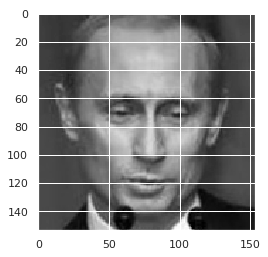

<Figure size 432x288 with 0 Axes>

In [16]:
#Example of an original image from the dataset
original_img = x_test[44]
original_image = original_img.reshape((154,154))
plt.imshow(original_image, cmap ='gray')
plt.figure()

(1, 23716)


<Figure size 432x288 with 0 Axes>

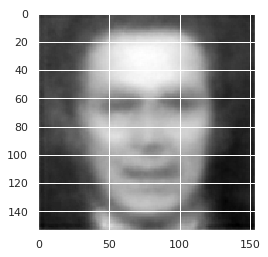

<Figure size 432x288 with 0 Axes>

In [17]:
#Example of the vae output
vae_img = x_test[44]
vae_img= vae_img.reshape(-1,154*154)
vae_img_plot = vae.predict(vae_img)
print(vae_img_plot.shape)
vae_img_plot = vae_img_plot.reshape(154,154)
plt.imshow(vae_img_plot, cmap='gray')
plt.figure()

#Removing the decoder and appending a Feed Forward Neural Network to the outputs of the encoder

In [18]:
enc_model = Sequential()
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(100, activation='relu')(latent_inputs)
y = Dense(100, activation='relu')(x)
output_2 = Dense(n_classes, activation='softmax')(y)
enc_ffn = Model(latent_inputs, output_2, name='enc_ffn')
enc_ffn.summary()
plot_model(enc_ffn, to_file='encoder_ffn.png', show_shapes=True)

enc_ffn.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam', metrics=['accuracy'])

print(y_test.shape)

enc_ffn.fit(encoder.predict(x_train)[2], y_classes, epochs=250, batch_size=256, verbose=2)
scores = enc_ffn.evaluate(encoder.predict(x_test)[2], y_classes_test, verbose=0)
print("Part 2 score: ",scores)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 24)                2424      
Total params: 13,024
Trainable params: 13,024
Non-trainable params: 0
_________________________________________________________________
(6312,)
Instructions for updating:
Use tf.cast instead.
Epoch 1/250
 - 0s - loss: 3.1059 - acc: 0.1014
Epoch 2/250
 - 0s - loss: 2.8624 - acc: 0.1928
Epoch 3/250
 - 0s - loss: 2.6160 - acc: 0.2153
Epoch 4/250
 - 0s - loss: 2.4782 - acc: 0.2307
Epoch 5/250
 - 0s - loss: 

In [19]:
enc_ffn.summary()
plot_model(enc_ffn, to_file='enc_ffn.png', show_shapes=True)
f_outputs = enc_ffn(encoder(inputs)[2])
final_model = Model(inputs, f_outputs, name='final_model')
final_model.summary()
plot_model(final_model, to_file='final_model.png', show_shapes=True)
final_model.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 24)                2424      
Total params: 13,024
Trainable params: 13,024
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23716)             0         
_________________________________________________________________
encode

In [0]:
#Function to output the predictions with class labels and confidence percentage
def decode_predictions(pred, first_x):
  temp_list = pred.tolist()
  temp_list = temp_list[0] #Since predictions gives a 2D numpy array
  print(temp_list)
  for x in range(0, first_x):
    i = temp_list.index(max(temp_list))
    print(x+1,'-->', target_names[i], "with confidence of", temp_list[i]*100, '%')
    temp_list.remove(temp_list[i])
    
#Function to output class label from a given y_test or y_train array
def y2class(y_label):
  ind = y_label
  name = target_names[ind]
  print(name)
  print(ind)

#y_test2target_name(y_test[4])    
#decode_predictions(predictions, 3)

## Using VAE for image classification

[1.4750230548088439e-06, 0.2906632125377655, 1.8845709064407856e-06, 1.6051519195930307e-16, 0.07319874316453934, 0.00026224905741401017, 0.0012408372713252902, 0.028581246733665466, 0.21774423122406006, 1.1662200449791271e-07, 0.00968811847269535, 0.01948152855038643, 3.1045030368659354e-07, 1.5502320260818436e-10, 1.6998171759041725e-07, 0.04925394058227539, 0.25398778915405273, 0.011932218447327614, 2.0661490717405916e-16, 0.003087681019678712, 1.554114351165481e-05, 2.387041336349236e-14, 0.040858667343854904, 4.507067608017223e-09]
1 --> Alvaro Uribe with confidence of 29.06632125377655 %
2 --> John Ashcroft with confidence of 25.398778915405273 %
3 --> George W Bush with confidence of 21.774423122406006 %
None


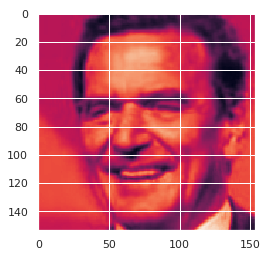

<Figure size 432x288 with 0 Axes>

In [21]:
first_img = x_train[18]
first_img = first_img.reshape((-1,154*154))
plot_img = first_img.reshape((154,154))
plt.imshow(plot_img)
plt.figure()
print(decode_predictions(final_model.predict(first_img),3))

plot_img *= 255.
# print(plot_img)
# print(first_img)
plot_img = plot_img.astype(np.uint8)



# im = Image.fromarray(plot_img)
# im.save("VAE_LFW_Original_BIM.png")

# # Downloading image
# from google.colab import files
# files.download("VAE_LFW_Original_BIM.png" ) 


# # Hacking Image

In [22]:
#Installing dependencies
!pip install foolbox

In [0]:
import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.attacks import DeepFoolAttack, BIM, GradientAttack, SaliencyMapAttack
from foolbox.criteria import TargetClassProbability
import numpy as np
import keras

## Hacking an image in the LFW dataset

This repo. contains the implementation of 4 attacks on a Convolutional VAE trained on the LFW dataset. They are the BIM, LBFGS attack, Gradient attack and Saliency Map Attack. To implement these, please uncomment one of the attacks in the code below. 

In [28]:
#Initializing the fool model
fmodel = KerasModel(final_model, bounds=(0, 1)) 

image = x_train[12] 
label = 14 


# run the attack (Uncomment any one line of the 4 to run that attack)

# attack = BIM(model=fmodel, criterion=TargetClassProbability(3, p=.50))
attack = LBFGSAttack(model=fmodel, criterion=TargetClassProbability(3, p=.5))
# attack = GradientAttack(model=fmodel, criterion=TargetClassProbability(10, p=.5))
# attack = SaliencyMapAttack(model=fmodel, criterion=TargetClassProbability(1, p=.2))

adversarial = attack(image, label)

# show results
print(np.argmax(fmodel.predictions(adversarial)))
print(foolbox.utils.softmax(fmodel.predictions(adversarial))[2])
adversarial_rgb = adversarial #image[:, :, ::-1] For BGR
# print(adversarial_rgb.shape)
# preds = final_model.predict(adversarial_rgb)

#print("Prediction: ", preds)
print("Adversarial done!")

3
0.011573328
Adversarial done!


Original Image
[1.310137304244563e-05, 5.4138121936830874e-12, 0.0199718177318573, 1.802621663049564e-10, 0.1728990077972412, 0.02678004838526249, 8.580956887271896e-07, 0.03394030034542084, 0.020426204428076744, 0.005790158174932003, 0.001965811476111412, 0.6780694723129272, 0.007748051080852747, 2.1853629732504487e-05, 6.853089871583506e-05, 0.0003884167526848614, 2.7786332793766633e-05, 0.031829219311475754, 8.555639481009082e-28, 4.033474760944955e-05, 1.4263930836477812e-07, 5.595644199373952e-20, 1.88162211998133e-05, 3.5130874068913076e-22]
1 --> Hugo Chavez with confidence of 67.80694723129272 %
None


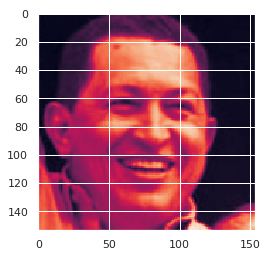

In [29]:
print("Original Image")

plot_imgBIM = x_train[12]
plot_imgBIM = plot_imgBIM.reshape((-1,154*154))
print(decode_predictions(final_model.predict(plot_imgBIM),1))
plot_imgBIM = plot_imgBIM.reshape((154,154))
plt.imshow(plot_imgBIM)
plt.show()
plot_imgBIM *= 255.
plot_imgBIM = plot_imgBIM.astype(np.uint8)

im = Image.fromarray(plot_imgBIM)
im.save("VAE_LFW_Original_BIM.png")

# Downloading image
from google.colab import files
files.download("VAE_LFW_Original_BIM.png" ) 

Adversarial Image
[7.108746841107143e-23, 3.048008636596933e-07, 0.01963193155825138, 0.3814658522605896, 0.00046652997843921185, 0.14797449111938477, 0.0522976890206337, 0.3376303017139435, 1.4382871995621826e-05, 4.592295710370564e-10, 0.007192948367446661, 2.014614750578403e-07, 0.01263787504285574, 0.029015837237238884, 1.924645630424493e-06, 1.938080231411732e-06, 9.768476593308151e-05, 1.4000438479543362e-34, 3.6199689079641217e-13, 1.2603049981407821e-05, 1.427189459946021e-07, 2.9385901756598603e-23, 0.011557172052562237, 1.8227937914616632e-07]
1 --> Ariel Sharon with confidence of 38.14658522605896 %


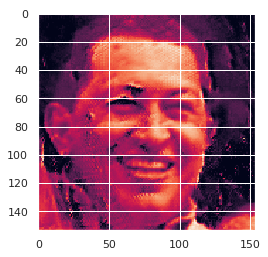

<Figure size 432x288 with 0 Axes>

In [30]:
print("Adversarial Image")
adv_imgBIM = adversarial_rgb
adv_imgBIM = adv_imgBIM.reshape((-1, 154*154))
decode_predictions(final_model.predict(adv_imgBIM),1)


adv_imgBIM = adv_imgBIM.reshape((154, 154))
#adv_img = adv_img.astype(np.uint8)
plt.imshow(adv_imgBIM)
plt.show()
plt.figure()

adv_imgBIM *= 255.
adv_imgBIM = adv_imgBIM.astype(np.uint8)


im = Image.fromarray(adv_imgBIM)
im.save("VAE_LFW_Hacked_BIM.png")

# Downloading image
from google.colab import files
files.download("VAE_LFW_Hacked_BIM.png" ) 